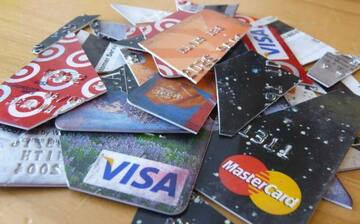

## Dataset Information

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

* A XGBoost model is built to predict if a client will default on next payment, **final auc: 0.793**

In [ ]:
import numpy as np 
import pandas as pd 

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
credit_card = pd.read_csv('../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')

credit_card.drop(columns='ID', inplace=True) # drop ID, as this is irrelevant

credit_card.rename(columns={'default.payment.next.month':'default'}, inplace=True)

In [ ]:
credit_card.head()

In [ ]:
credit_card.info()

In [ ]:
credit_card.describe()

## There are 25 variables:

ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

## There are no missing values

In [ ]:
credit_card.isnull().sum()

# EDA

Data is not very balanced, there are way more `non-default` than `default`

In [ ]:
# count 

plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default')
plt.title('default', size=19)
plt.show()

In [ ]:
print('non-default:', len(credit_card.default) - sum(credit_card.default))
print('default:', sum(credit_card.default))

SEX: Gender (1=male, 2=female)

For `non-default`, there are more female than male

For `default`, there are slightly more female than male

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default', hue='SEX')
plt.title('default', size=19)
plt.show()

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default', hue='EDUCATION')
plt.title('default', size=19)
plt.show()

MARRIAGE: Marital status (1=married, 2=single, 3=others)

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default', hue='MARRIAGE')
plt.title('default', size=19)
plt.show()

Age

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(credit_card.AGE)
plt.title('Age', size=19)
plt.show()

default vs age

distrbution of age between the two classes showed not much of difference

In [ ]:
non_default = credit_card.loc[credit_card.default == 0]
default = credit_card.loc[credit_card.default == 1]

plt.figure(figsize=(6,6))
sns.distplot(non_default.AGE)
plt.title('non-default', size=19)
plt.show()

plt.figure(figsize=(6,6))
sns.distplot(non_default.AGE)
plt.title('default', size=19)
plt.show()

# XGBoost

In [ ]:
cc = credit_card.copy()

# base X and y
y = cc.iloc[:,-1]
X = cc.iloc[:,0:-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

In [ ]:
# proportion of 0 and 1 in train/test, just to make sure train and test had same distribution

print(y_train.value_counts()/len(y_train))
print('\n')
print(y_test.value_counts()/len(y_test))

## set `scale_pos_weight`

The data is imbalanced, so we need to set `scale_pos_weight`, from EDA:

* non-default: 23364
* default: 6636

so preliminary `scale_pos_weight` = 23364/6636 = 3.52

In [ ]:
model = XGBClassifier(scale_pos_weight=3.52, eval_metric='auc')
model.fit(x_train, y_train)

In [ ]:
pred = model.predict_proba(x_test)
roc_auc_score(y_test, pred[:,1])

# Hyperparameter Tuning

## Tune `scale_pos_weight`

best cv score: 0.7641200092121778 {'scale_pos_weight': 3.65}

In [ ]:
# tune scale_pos_weight

model = XGBClassifier()

scale_pos_weight = [3.45, 3.5, 3.55, 3.6, 3.65]
param = dict(scale_pos_weight = scale_pos_weight)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
grid_result = grid_search.fit(X, y)

print('best cv score:', grid_result.best_score_, grid_result.best_params_)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print('%f, (%f),%r' % (mean, std, param))

plt.errorbar(scale_pos_weight, means, yerr=stds)
plt.title('CV error vs n_estimators')
plt.show()

## Tune `n_estimator`

best cv score: 0.7711229012960673 {'n_estimators': 50}

In [ ]:
# # tune n_estimator

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # n_estimators : 50 ~ 400
# n_estimators = range(50, 400, 50)
# param = dict(n_estimators = n_estimators)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(n_estimators, means, yerr=stds)
# plt.title('CV error vs n_estimators')
# plt.show()

## Tune `max_depth`

best cv score: 0.7791281026402791 {'max_depth': 3}

In [ ]:
# # tune tree size

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # tree depth = 1,3,5,7,9
# max_depth = [1,3,5,7,9]
# param = dict(max_depth = max_depth)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(max_depth, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## Tune `learning_rate`

best cv score: 0.7814509434904099 {'learning_rate': 0.05}

In [ ]:
# # tune learning rate

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # learning rate
# learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# param = dict(learning_rate = learning_rate)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(learning_rate, means, yerr=stds)
# plt.title('CV error vs learning rate')
# plt.show()

## searching for best combination of `n_estimators` and `learning_rate`

best cv score: 0.7816162765619434 {'learning_rate': 0.01, 'n_estimators': 400}

0.781182, (0.009172),{'learning_rate': 0.01, 'n_estimators': 300}

0.781451, (0.008836),{'learning_rate': 0.05, 'n_estimators': 100}

In [ ]:
# # tune learning rate and n_estimator

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # learning rate and n_estimator
# learning_rate = [0.005, 0.01, 0.05, 0.1, 0.2]
# n_estimators = [50, 100, 200, 300, 400]
# param = dict(learning_rate = learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))



## Tuning Stochastic Gradient Boosting

## row subsampling

est cv score: 0.7641200092121778 {'subsample': 1.0}

using all the rows

In [ ]:
# # row sampling

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # learning rate and n_estimator
# subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param = dict(subsample = subsample)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(subsample, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## column subsampling before creating a tree

best cv score: 0.7664118466032764 {'colsample_bytree': 0.2}

In [ ]:
# # tune column sampling

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param = dict(colsample_bytree = colsample_bytree)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(colsample_bytree, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## column subsampling for each split in a tree

best cv score: 0.7689689215616526 {'colsample_bylevel': 0.1}

In [ ]:
# # tune column sub sampling

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param = dict(colsample_bylevel = colsample_bylevel)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(colsample_bylevel, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## Hyperparameter Tuning, Part 2

combining all the results from above

best cv score: 0.7815174509656737 {'colsample_bytree': 0.4, 'learning_rate': 0.06, 'max_depth': 3, 'min_child_weight': 1.8}

In [ ]:
# # tuning all parameters togather

# model = XGBClassifier(n_estimators=100, scale_pos_weight=3.65, eval_metric='auc')

# learning_rate = [0.04, 0.045, 0.05, 0.055, 0.06]
# max_depth = [2, 3]
# colsample_bytree = [0.2, 0.3, 0.4, 0.5]
# min_child_weight = [1, 1.8, 2.0, 2.2]
# param = dict(learning_rate=learning_rate, max_depth = max_depth, colsample_bytree=colsample_bytree, min_child_weight=min_child_weight)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# Final Model

Using the results from all the hyperparameter tuning from above, the final auc is 0.793

In [ ]:
# final model
model = XGBClassifier(n_estimators=100, learning_rate=0.06, colsample_bytree=0.4, max_depth=3, min_child_weight=1.8,scale_pos_weight=3.65 )
model.fit(x_train, y_train)

pred = model.predict_proba(x_test)
print('auc:', roc_auc_score(y_test, pred[:,1]))


## Confusion Matrix

In [ ]:
pred = model.predict(x_test)
conf_mx = pd.crosstab(pred, y_test, rownames=['Prediction'], colnames=['True Value'])

plt.figure(figsize=(6,6))
sns.heatmap(conf_mx, annot=True, fmt='g', square=True,
            xticklabels=['non-default', 'default'],
           yticklabels=['non-default', 'default'],
           cmap="Greens")
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Feature Importance

The most important features are:

* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

This makes sense, since September is the most recent Month in the data, the ability to repay the bill in the previous month would be a good indicator of repayment in next month.

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
xgb.plot_importance(model, height=0.6, ax=ax, color='red')
plt.show()

## Please upvote if you found this notebook useful, THANK YOU